**Models, feature selection, report results**

In [2]:
%matplotlib inline
import json
import nltk
import pickle
import re
import scipy
import sklearn
import string
import numpy as np
import pandas as pd
import pprint
pp = pprint.PrettyPrinter(width=100)
from collections import defaultdict

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
"""load preprocessed dictionary of pair samples with author features"""

pairs_authorf = pickle.load(open('/home/username/workspace/data/output/_jobs/features/pairs_post_author_features.pickle','rb'))

In [5]:
pairs_authorf[0]

{'a': {'author': 'DaystarEld',
  'comments': [{'archived': False,
    'author': 'DaystarEld',
    'author_flair_css_class': None,
    'author_flair_text': '11Δ',
    'body': 'The majority of your points seem predicated on the idea that a) Basic Income requires a flat tax or rejects progressive taxation, and b) that absolutely every social program must be scrapped for a BI to take effect.\n\nNeither of these are true. Of course there are many conservatives or right-libertarian who would prefer those outcomes, but there are also many liberals and left-libertarians who do not.\n\nThe title of your CMV is worded incorrectly. You are arguing against not Basic Income, but the questions of how to pay for it and what exactly would be "replaced."\n\nIf that doesn\'t change your view, I\'m really not sure what would.  The post is very well written and laid out, it\'s just a perfectly shot arrow aimed at the wrong target.',
    'controversiality': 0,
    'created_utc': '1427651011',
    'delta': 

In [6]:
# distribution of authors in pairs
pairs_op_a = list(map(lambda x: sorted([x['op']['author'], x['a']['author']]), pairs_authorf))
pairs_op_a[0]

['DaystarEld', 'gobears10']

In [143]:
_unique_pairs = {}
for p in pairs_op_a:
    t = tuple(p)
    if t in _unique_pairs:
        _unique_pairs[t] += 1
    else:
        _unique_pairs[t] = 1

In [144]:
_unique_list = []
for x in _unique_pairs.items():
    _unique_list.append({})

14928

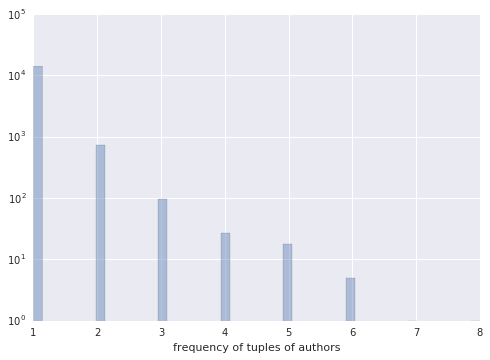

In [151]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

f, ax = plt.subplots()

g = sns.distplot(list(_unique_pairs.values()), kde=False)
g.set(xlabel='frequency of tuples of authors')
g.set_yscale('log')
# f.savefig('/home/username/workspace/figures/tmp.pdf')

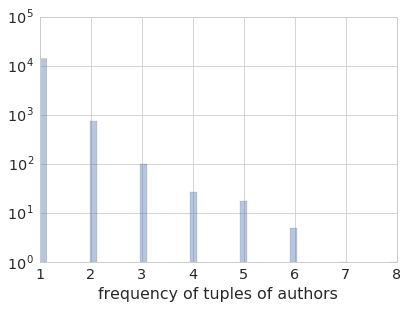

In [286]:
f, ax = plt.subplots()

sns.set(font_scale=1.8, style="whitegrid", context="paper")
sns.set_color_codes("pastel")

g = sns.distplot(list(_unique_pairs.values()), kde=False)
g.set(xlabel='frequency of tuples of authors')
g.set_yscale('log')

f.savefig('/home/username/workspace/figures/tuples_authors_freq.pdf')

In [3]:
len(pairs_authorf)

16050

In [4]:
pairs_authorf[0].keys()

dict_keys(['features', 'op', 'delta', 'a'])

In [5]:
pairs_authorf[0]['features']['author'].keys()

dict_keys(['subreddit_topcategory_tfidf_pca', 'category_raw', 'entity_pca5', 'liwc_scores', 'entity_raw', 'entity_cat_pca', 'subreddit_category_raw_pca', 'entity_cat_tfidf', 'subreddit_raw', 'subreddit_tfidf', 'percentiles', 'subreddit_pca5', 'sentity_topcat_pca', 'subreddit_category_tfidf', 'sentity_topcat', 'entity_topcat_tfidf', 'entity_cat_raw', 'subreddit_category_raw', 'entity_topcat_raw', 'bigfive', 'raw_scores', 'entity_tfidf', 'subreddit_topcategory_raw_pca', 'category_tfidf', 'entity_topcat_pca', 'subreddit_category_tfidf_pca', 'sentity_cat', 'sentity_cat_pca'])

In [6]:
sorted(list(pairs_authorf[0]['features']['author'].keys()), key=lambda x:x)

['bigfive',
 'category_raw',
 'category_tfidf',
 'entity_cat_pca',
 'entity_cat_raw',
 'entity_cat_tfidf',
 'entity_pca5',
 'entity_raw',
 'entity_tfidf',
 'entity_topcat_pca',
 'entity_topcat_raw',
 'entity_topcat_tfidf',
 'liwc_scores',
 'percentiles',
 'raw_scores',
 'sentity_cat',
 'sentity_cat_pca',
 'sentity_topcat',
 'sentity_topcat_pca',
 'subreddit_category_raw',
 'subreddit_category_raw_pca',
 'subreddit_category_tfidf',
 'subreddit_category_tfidf_pca',
 'subreddit_pca5',
 'subreddit_raw',
 'subreddit_tfidf',
 'subreddit_topcategory_raw_pca',
 'subreddit_topcategory_tfidf_pca']

In [126]:
pairs_authorf[0].keys()

dict_keys(['features', 'op', 'delta', 'a'])

In [8]:
### split pairs into training and heldout
from datetime import datetime
d = datetime.strptime('2017-04-01', "%Y-%m-%d").timestamp()
training_pairs = list(filter(lambda x: int(x['op']['created_utc']) < d, pairs_authorf))
heldout_pairs = list(filter(lambda x: int(x['op']['created_utc']) >= d, pairs_authorf))
print(len(training_pairs), len(heldout_pairs))

12496 3554


In [9]:
author_history_words_dict = pickle.load(open('/home/username/workspace/data/output/_jobs/features/author_history_words_dict.pickle','rb'))

In [10]:
author_history_words_dict['huadpe']

(2599100, 1304189)

In [14]:
"""prepare author-history-features (submissions+comments count)"""

# author_subreddit_vec = pickle.load(open('/home/username/workspace/data/output/_jobs/features/author_subreddit_vec.pickle','rb'))
author_category_vec = pickle.load(open('/home/username/workspace/data/output/_jobs/features/author_category_vec.pickle','rb'))

In [15]:
history = {}
for a,v in author_subreddit_vec.items():
    history[a] = sum(list(v['raw'].data))
len(history)

12287

In [16]:
# gobears10', 'DaystarEld'
history['huadpe']

20503.0

In [18]:
unique = list(sorted(set(history.values()), key=lambda x:x))
print(len(unique), min(unique), max(unique))

6223 1.0 671574.0


In [318]:
unique = list(sorted(history.values(), key=lambda x:x))
print(len(unique), min(unique), max(unique))

12287 1.0 671574.0


In [23]:
n = int(len(unique) / 5)
print('n',n)
chunks = [unique[i:i + n] for i in range(0, len(unique), n)]
c = len(chunks)-1
chunks[c-1] = chunks[c-1] + chunks[c]
chunks.remove(chunks[c])
[(len(c), min(c), max(c)) for c in chunks]

n 1244


[(1244, 1.0, 1294.0),
 (1244, 1295.0, 2967.0),
 (1244, 2968.0, 5564.0),
 (1244, 5566.0, 10921.0),
 (1247, 10926.0, 671574.0)]

In [25]:
value_chunks = {}
for k,c in enumerate(chunks):
    for v in c:
        value_chunks[v] = k
len(value_chunks)

6223

In [26]:
history_chunks = {}
for a,v in history.items():
    history_chunks[a] = (v, value_chunks[v])
len(history_chunks)

12287

In [27]:
history_chunks['huadpe']

(20503.0, 4)

In [350]:
import pickle
pickle.dump(history_chunks, open('/home/username/workspace/data/output/_jobs/features/history_chunks5.pickle','wb'))
# history_chunks = pickle.load(open('/home/username/workspace/data/output/_jobs/features/history_chunks5.pickle','rb'))

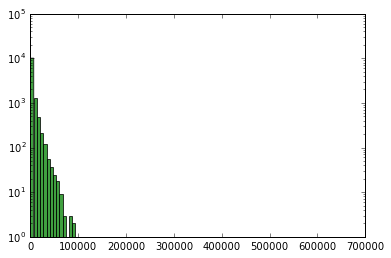

In [235]:
data = list(history.values())

import matplotlib.pyplot as plt
n, bins, patches = plt.hist(data, 100, normed=False, facecolor='g', alpha=0.75, log=True)
plt.show()

In [123]:
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

In [ ]:
### todo: correlation of history-delta

correlation_matrix = housing.corr()   #creating a heatmap of the attributes in the dataset
plt.subplots(figsize=(8,6))
sns.heatmap(correlation_matrix, center=0, annot=True, linewidths=.3)

In [ ]:
sns.distplot(data) # showing the distribution of the median_income variable in the dataset
plt.show()                                  # check the distplot params though. see how you can make it prettier

In [100]:
def add_prefix(d, prefix, top_cats=None):
    newd = {}
    for k,v in d.items():
        if top_cats is not None:
            if k in top_cats:
                newd[prefix+'_'+k] = v
        else:
            newd[prefix+'_'+k] = v
    return newd

def prepare_dict(x):
    _dict = defaultdict(dict)
    
#     _dict['authors'] = (x['op']['author'], x['a']['author'])
    
    ### history chunks
#     _dict['chunk'] = min(history_chunks[x['op']['author']][1], history_chunks[x['a']['author']][1])
    _dict['chunk'] = min(history[x['op']['author']], history[x['a']['author']])
    _dict['chunk_words_min'] = min(author_history_words_dict[x['op']['author']][0], author_history_words_dict[x['a']['author']][0])
    _dict['chunk_words_max'] = max(author_history_words_dict[x['op']['author']][0], author_history_words_dict[x['a']['author']][0])
    _dict['chunk_words_avg'] = (author_history_words_dict[x['op']['author']][0] + author_history_words_dict[x['a']['author']][0]) / 2
    
    ### words/interplay features
    _dict['words']['op_all'] = x['features']['path']['post']['words_op']['all']
    _dict['words']['root_all'] = x['features']['root']['post']['words_a_root']['all']
    _dict['words']['path_all'] = x['features']['path']['post']['words_a_path']['all']
    _dict['interplay_root'].update(x['features']['root']['interplay'])
    _dict['interplay_path'].update(x['features']['path']['interplay'])

# #     ### traits_similarities
    _dict['traits_sim']['bigfive'] = x['features']['author']['bigfive']
    _dict['traits_sim']['percentiles'] = x['features']['author']['percentiles']
    _dict['traits_sim']['raw_scores'] = x['features']['author']['raw_scores']
    _dict['traits_sim']['liwc_scores'] = x['features']['author']['liwc_scores']
    
#     ### traits_features
    _dict['traits_feat_b'].update(dict( [('op'+str(k),v) for k,v in enumerate(x['op']['traits']['bigfive'].tolist()[0])] ))
    _dict['traits_feat_b'].update(dict( [('a'+str(k),v) for k,v in enumerate(x['a']['traits']['bigfive'].tolist()[0])] ))

    _dict['traits_feat_p'].update(dict( [('op'+str(k),v) for k,v in enumerate(x['op']['traits']['percentiles'].tolist()[0])] ))
    _dict['traits_feat_p'].update(dict( [('a'+str(k),v) for k,v in enumerate(x['a']['traits']['percentiles'].tolist()[0])] ))

    _dict['traits_feat_r'].update(dict( [('op'+str(k),v) for k,v in enumerate(x['op']['traits']['raw_scores'].tolist()[0])] ))
    _dict['traits_feat_r'].update(dict( [('a'+str(k),v) for k,v in enumerate(x['a']['traits']['raw_scores'].tolist()[0])] ))


    _dict['traits_feat_bdif'].update(dict( [('bf'+str(i),op-a) for i,(op,a) in enumerate(zip(x['op']['traits']['bigfive'].tolist()[0],x['a']['traits']['bigfive'].tolist()[0]))] ))
    _dict['traits_feat_pdif'].update(dict( [('p'+str(i),op-a) for i,(op,a) in enumerate(zip(x['op']['traits']['percentiles'].tolist()[0],x['a']['traits']['percentiles'].tolist()[0]))] ))
    _dict['traits_feat_rdif'].update(dict( [('r'+str(i),op-a) for i,(op,a) in enumerate(zip(x['op']['traits']['raw_scores'].tolist()[0],x['a']['traits']['raw_scores'].tolist()[0]))] ))
    
#     ### beliefs similarities
    _dict['belief_ssim']['subreddit_tfidf'] = x['features']['author']['subreddit_tfidf']
    _dict['belief_ssim']['subreddit_raw'] = x['features']['author']['subreddit_raw']
    _dict['belief_csim']['category_tfidf'] = x['features']['author']['category_tfidf']
    _dict['belief_csim']['category_raw'] = x['features']['author']['category_raw']
    _dict['belief_esim']['entity_tfidf'] = x['features']['author']['entity_tfidf']
    _dict['belief_esim']['entity_raw'] = x['features']['author']['entity_raw']

#     ### beliefs category similarities
    _dict['belief_sim_scatt'].update(add_prefix(x['features']['author']['subreddit_category_tfidf'], 'sct'))
    _dict['belief_sim_scatr'].update(add_prefix(x['features']['author']['subreddit_category_raw'], 'scr'))

    _dict['belief_sim_scattp'].update(add_prefix(x['features']['author']['subreddit_category_tfidf_pca'], 'sctp'))
    _dict['belief_sim_spcatrp'].update(add_prefix(x['features']['author']['subreddit_category_raw_pca'], 'scrp'))

    _dict['belief_sim_stcattp'].update(add_prefix(x['features']['author']['subreddit_topcategory_tfidf_pca'], 'stctp'))
    _dict['belief_sim_stcatrp'].update(add_prefix(x['features']['author']['subreddit_topcategory_raw_pca'], 'stcrp'))

    _dict['belief_sim_ecatt'].update(add_prefix(x['features']['author']['entity_cat_tfidf'], 'ect'))
    _dict['belief_sim_ecatr'].update(add_prefix(x['features']['author']['entity_cat_raw'], 'ecr'))
    _dict['belief_sim_ecatp'].update(add_prefix(x['features']['author']['entity_cat_pca'], 'ecp'))

    _dict['belief_sim_etcatt'].update(add_prefix(x['features']['author']['entity_topcat_tfidf'], 'ett'))
    _dict['belief_sim_etcatr'].update(add_prefix(x['features']['author']['entity_topcat_raw'], 'etr'))
    _dict['belief_sim_etcatp'].update(add_prefix(x['features']['author']['entity_topcat_pca'], 'etp'))

    _dict['belief_sim_secat'].update(add_prefix(x['features']['author']['sentity_cat'], 'sec'))
    _dict['belief_sim_secatp'].update(add_prefix(x['features']['author']['sentity_cat_pca'], 'secp'))
    _dict['belief_sim_setcat'].update(add_prefix(x['features']['author']['sentity_topcat'], 'set'))
    _dict['belief_sim_setcatp'].update(add_prefix(x['features']['author']['sentity_topcat_pca'], 'setp'))
    
    _dict['delta'] = x['delta']
    return dict(_dict)

training_data = list(map(lambda x: prepare_dict(x), training_pairs))
heldout_data = list(map(lambda x: prepare_dict(x), heldout_pairs))
first = training_data[0]
first.keys()

dict_keys(['belief_sim_secat', 'belief_ssim', 'belief_sim_setcatp', 'words', 'interplay_root', 'belief_sim_ecatp', 'traits_feat_p', 'chunk_words_max', 'belief_sim_scattp', 'traits_feat_b', 'belief_sim_etcatp', 'belief_csim', 'interplay_path', 'belief_sim_stcattp', 'traits_feat_pdif', 'belief_sim_ecatr', 'belief_sim_ecatt', 'belief_sim_scatr', 'traits_feat_bdif', 'belief_sim_etcatt', 'belief_sim_spcatrp', 'chunk', 'traits_sim', 'belief_sim_scatt', 'belief_sim_etcatr', 'chunk_words_avg', 'delta', 'chunk_words_min', 'traits_feat_r', 'belief_sim_stcatrp', 'traits_feat_rdif', 'belief_sim_setcat', 'belief_esim', 'belief_sim_secatp'])

In [120]:
first['chunk']

239.0

In [118]:
sorted(first['interplay_root'].keys())

['words_common_all',
 'words_common_content',
 'words_common_stop',
 'words_jaccard_all',
 'words_jaccard_content',
 'words_jaccard_stop',
 'words_op_all',
 'words_op_content',
 'words_op_stop',
 'words_reply_all',
 'words_reply_content',
 'words_reply_stop']

In [ ]:
# training_df = pd.DataFrame(training_data)
# heldout_df = pd.DataFrame(heldout_data)

In [101]:
training_df = pd.io.json.json_normalize(training_data, sep='_')
heldout_df = pd.io.json.json_normalize(heldout_data, sep='_')
print(len(training_df.columns))
# training_df.head(5)

In [102]:
print(len(training_df.columns))

7263


In [252]:
df = training_df.drop(['delta', 'chunk', 'chunk_words_min', 'chunk_words_max', 'chunk_words_avg'], axis=1)
df_norm = (df - df.mean()) / (df.max() - df.min())
df_norm = df_norm.fillna(0.0)

X_train = df_norm
# X_train['chunk'] = training_df['chunk']
# X_train['chunk_words_min'] = training_df['chunk_words_min']
# X_train['chunk_words_max'] = training_df['chunk_words_max']
# X_train['chunk_words_avg'] = training_df['chunk_words_avg']
y_train = training_df['delta']
print(X_train.shape)
# X_train.head(5)

(12496, 7258)


In [207]:
df = heldout_df.drop(['delta', 'chunk'], axis=1)
df_norm = (df - df.mean()) / (df.max() - df.min())
df_norm = df_norm.fillna(0.0)

# X_heldout = df_norm
# X_heldout['chunk'] = heldout_df['chunk']
# y_heldout = heldout_df['delta']
# print(X_heldout.shape)
# X_heldout.head(5)

heldout_norm = df_norm
# heldout_norm['chunk'] = heldout_df['chunk']
heldout_norm['chunk_words_min'] = heldout_df['chunk_words_min']
heldout_norm['chunk_words_max'] = heldout_df['chunk_words_max']
heldout_norm['chunk_words_avg'] = heldout_df['chunk_words_avg']
heldout_norm['delta'] = heldout_df['delta']

In [209]:
heldout_norm.shape

(3554, 7262)

In [214]:
heldout_norm[['chunk_words_min', 'chunk_words_max', 'chunk_words_avg']].head(5)

,chunk_words_min,chunk_words_max,chunk_words_avg
0,100069,318656,209362.5
1,100069,669092,384580.5
2,100069,1022605,561337.0
3,37209,100069,68639.0
4,452492,2396893,1424692.5


In [211]:
heldout_norm['chunk_words_min'].describe()

count    3.554000e+03
mean     1.275811e+05
std      2.090625e+05
min      1.145000e+03
25%      1.938625e+04
50%      5.183700e+04
75%      1.364470e+05
max      3.145837e+06
Name: chunk_words_min, dtype: float64

In [223]:
bins = [0, 20000, 50000, 130000, np.inf]
names = ['<20k', '20k-50k', '50k-130k', '130k+']
# X_train['group'] = pd.cut(X_train['chunk'], bins, labels=names)
heldout_norm['group'] = pd.cut(heldout_norm['chunk_words_min'], bins, labels=names)

In [213]:
heldout_norm.groupby('group')['delta'].count()

group
<20k        901
20k-50k     838
50k-130k    852
130k+       963
Name: delta, dtype: int64

In [192]:
heldout_norm['group'] = pd.cut(heldout_norm['chunk'], bins, labels=names)

In [224]:
heldout_norm.head(5)['group']

0    50k-130k
1    50k-130k
2    50k-130k
3    20k-50k 
4    130k+   
Name: group, dtype: category
Categories (4, object): [<20k < 20k-50k < 50k-130k < 130k+]

In [36]:
heldout_df['chunk'].head(5)

0    2844.0
1    2844.0
2    2844.0
3     758.0
4    5432.0
Name: chunk, dtype: float64

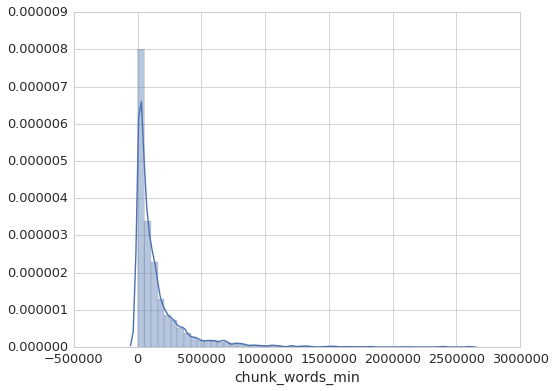

In [335]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

f, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale=1.6, style="whitegrid", context="paper")
sns.set_color_codes("pastel")

g = sns.distplot(training_df['chunk_words_min'])

# plt.xticks([0, 50000, 250000, 500000])
# for item in ax.get_xticklabels():
#     item.set_rotation(-45)

# g = sns.distplot(list(_unique_pairs.values()), kde=False)
# g.set(xlabel='frequency of tuples of authors')
# g.set_yscale('log')

f.savefig('/home/username/workspace/figures/history_words_dist.pdf')

In [225]:
heldout_df_chunks = heldout_norm
heldout_df_chunks['delta'] = heldout_df['delta']
groups_delta = heldout_df_chunks[heldout_df_chunks.delta == True].groupby('group')['delta'].count()
groups_nodelta = heldout_df_chunks[heldout_df_chunks.delta == False].groupby('group')['delta'].count()

groups_stats = pd.DataFrame()
groups_stats['delta'] = groups_delta
groups_stats['nodelta'] = groups_nodelta

In [226]:
groups_stats.head(6)

,delta,nodelta
group,,
<20k,471,430
20k-50k,418,420
50k-130k,447,405
130k+,502,461


In [220]:
print(groups_stats.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  delta &  nodelta \\
group    &        &          \\
\midrule
<20k     &  471 &  430 \\
20k-50k  &  418 &  420 \\
50k-130k &  447 &  405 \\
130k+    &  502 &  461 \\
\bottomrule
\end{tabular}



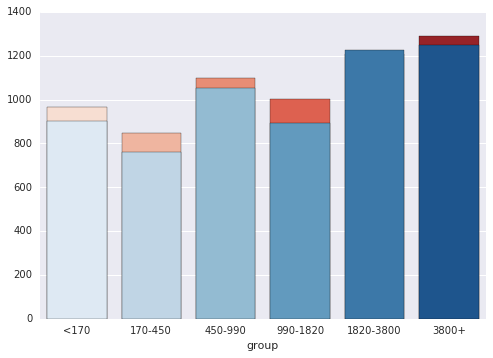

In [368]:
sns.barplot(x=groups_delta.index, y=groups_delta.values, palette="Reds")
sns.barplot(x=groups_nodelta.index, y=groups_nodelta.values, palette="Blues")
# plt.show()

In [54]:
heldout_df['chunk'].max()

61035.0

In [158]:
bins = [0, 170, 450, 990, 1820, 3800, np.inf]
names = ['<170', '170-450', '450-990', '990-1820', '1820-3800', '3800+']
X_train['group'] = pd.cut(X_train['chunk'], bins, labels=names)
X_heldout['group'] = pd.cut(X_heldout['chunk'], bins, labels=names)

In [159]:
X_heldout.head(5)

,belief_csim_category_raw,belief_csim_category_tfidf,belief_esim_entity_raw,belief_esim_entity_tfidf,belief_sim_ecatp_ecp_.NET,belief_sim_ecatp_ecp_30 Rock,belief_sim_ecatp_ecp_3D Printing,belief_sim_ecatp_ecp_3DS,belief_sim_ecatp_ecp_A Song of Ice and Fire,belief_sim_ecatp_ecp_AI,...,traits_feat_rdif_r9,traits_sim_bigfive,traits_sim_liwc_scores,traits_sim_percentiles,traits_sim_raw_scores,words_op_all,words_path_all,words_root_all,chunk,group
0,0.110053,-0.019409,0.144224,0.006880,0.0,-0.000281,0.000166,-0.000281,-0.000076,0.0,...,-0.049620,0.127107,0.022603,0.132858,0.118449,0.032034,0.018776,0.127078,2844.0,1820-3800
1,0.140893,-0.042357,0.284182,0.084543,0.0,-0.000281,0.000166,-0.000281,-0.000076,0.0,...,-0.026677,0.137729,0.020587,0.147544,0.123104,0.032034,-0.007057,0.025881,2844.0,1820-3800
2,0.187133,0.116670,0.367314,0.119931,0.0,-0.000281,0.000166,-0.000281,-0.000076,0.0,...,-0.051613,0.036954,0.020212,0.067768,0.051126,0.032034,-0.022022,-0.104696,2844.0,1820-3800
3,0.122533,0.322412,0.030934,0.028171,0.0,-0.000281,0.000166,-0.000281,-0.000076,0.0,...,-0.056028,0.036790,0.015181,0.086548,0.100819,0.032034,-0.022378,-0.067699,758.0,450-990
4,0.373818,0.044343,-0.004901,0.204860,0.0,-0.000281,0.000166,-0.000281,-0.000076,0.0,...,0.142176,-0.151497,0.019223,-0.037835,-0.049419,-0.026346,-0.027901,-0.101431,5432.0,3800+


In [ ]:
X_train.groupby('group').count()

In [161]:
X_train = X_train.drop(['chunk'], axis=1)
X_heldout = X_heldout.drop(['chunk'], axis=1)

In [191]:
for strata in heldout_norm.groupby('group'):
    print(strata[1].columns)

Index(['belief_csim_category_raw', 'belief_csim_category_tfidf',
       'belief_esim_entity_raw', 'belief_esim_entity_tfidf',
       'belief_sim_ecatp_ecp_.NET', 'belief_sim_ecatp_ecp_30 Rock',
       'belief_sim_ecatp_ecp_3D Printing', 'belief_sim_ecatp_ecp_3DS',
       'belief_sim_ecatp_ecp_A Song of Ice and Fire',
       'belief_sim_ecatp_ecp_AI',
       ...
       'traits_sim_bigfive', 'traits_sim_liwc_scores',
       'traits_sim_percentiles', 'traits_sim_raw_scores', 'words_op_all',
       'words_path_all', 'words_root_all', 'chunk', 'delta', 'group'],
      dtype='object', length=7261)
Index(['belief_csim_category_raw', 'belief_csim_category_tfidf',
       'belief_esim_entity_raw', 'belief_esim_entity_tfidf',
       'belief_sim_ecatp_ecp_.NET', 'belief_sim_ecatp_ecp_30 Rock',
       'belief_sim_ecatp_ecp_3D Printing', 'belief_sim_ecatp_ecp_3DS',
       'belief_sim_ecatp_ecp_A Song of Ice and Fire',
       'belief_sim_ecatp_ecp_AI',
       ...
       'traits_sim_bigfive', 'traits_

Accuracy: 58.08%

F1 Score: 60.39

COnfusion Matrix:
 [[ 928  788]
 [ 702 1136]]

               precision    recall  f1-score   support

       False       0.57      0.54      0.55      1716
        True       0.59      0.62      0.60      1838

   micro avg       0.58      0.58      0.58      3554
   macro avg       0.58      0.58      0.58      3554
weighted avg       0.58      0.58      0.58      3554



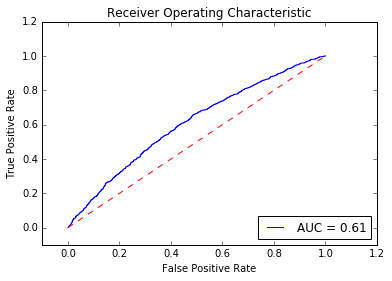

In [50]:
"""train on all of features"""

lr = sklearn.linear_model.LogisticRegression(penalty='l1')

# penalty = ['l1']
# C = np.logspace(0, 4, 10)
# hyperparameters = dict(C=C, penalty=penalty)    
# clf = GridSearchCV(lr, hyperparameters, cv=3, n_jobs = -1)
# best_model = clf.fit(X_train, y_train)
lr.fit(X_train, y_train)
best_model = lr

# print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
# print('Best C:', best_model.best_estimator_.get_params()['C'])

y_pred = best_model.predict(X_heldout)
y_pred_proba = best_model.predict_proba(X_heldout)[::,1]

print("Accuracy: {:.2f}%".format(accuracy_score(y_heldout, y_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_heldout, y_pred) * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_heldout, y_pred))
print("\n",classification_report(y_heldout, y_pred))

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_heldout, y_pred_proba)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [35]:
def get_labels(k):
    d = first
    return list(map(lambda x: k+'_'+x, pd.io.json.json_normalize(d[k], sep='_').columns))

In [36]:
post_groups = ['words', 'interplay_path', 'interplay_root']
post_columns = []
for g in post_groups:
    post_columns += get_labels(g)

In [38]:
keys = [e for e in first.keys() if e not in ('authors', 'chunk', 'chunk_words', 'chunk_stops', 'delta')]
feature_groups = list(sorted(keys, key=lambda x:x))
(feature_groups)

['belief_csim',
 'belief_esim',
 'belief_sim_ecatp',
 'belief_sim_ecatr',
 'belief_sim_ecatt',
 'belief_sim_etcatp',
 'belief_sim_etcatr',
 'belief_sim_etcatt',
 'belief_sim_scatr',
 'belief_sim_scatt',
 'belief_sim_scattp',
 'belief_sim_secat',
 'belief_sim_secatp',
 'belief_sim_setcat',
 'belief_sim_setcatp',
 'belief_sim_spcatrp',
 'belief_sim_stcatrp',
 'belief_sim_stcattp',
 'belief_ssim',
 'interplay_path',
 'interplay_root',
 'traits_feat_b',
 'traits_feat_bdif',
 'traits_feat_p',
 'traits_feat_pdif',
 'traits_feat_r',
 'traits_feat_rdif',
 'traits_sim',
 'words']

In [226]:
flat_features = ['belief_csim', 'belief_esim', 'belief_ssim',
    'interplay_path', 'interplay_root',
    'traits_sim', 'traits_feat_b', 'traits_feat_bdif',
    'words']

In [41]:
my_groups = [g for g in feature_groups if g not in post_groups]
my_groups

['belief_csim',
 'belief_esim',
 'belief_sim_ecatp',
 'belief_sim_ecatr',
 'belief_sim_ecatt',
 'belief_sim_etcatp',
 'belief_sim_etcatr',
 'belief_sim_etcatt',
 'belief_sim_scatr',
 'belief_sim_scatt',
 'belief_sim_scattp',
 'belief_sim_secat',
 'belief_sim_secatp',
 'belief_sim_setcat',
 'belief_sim_setcatp',
 'belief_sim_spcatrp',
 'belief_sim_stcatrp',
 'belief_sim_stcattp',
 'belief_ssim',
 'traits_feat_b',
 'traits_feat_bdif',
 'traits_feat_p',
 'traits_feat_pdif',
 'traits_feat_r',
 'traits_feat_rdif',
 'traits_sim']

In [42]:
traits_beliefs_columns = []
for g in my_groups:
    traits_beliefs_columns += get_labels(g)
len(traits_beliefs_columns)

7231

In [79]:
columns = get_labels('words')
# columns
_X_train = X_train['words_op_all']
print(_X_train.shape)
if _X_train.shape == (_X_train.shape[0],):
    _X_train = _X_train.reshape(-1, 1)
    print(_X_train.shape)


(12496,)
(12496, 1)


In [230]:
'chunk' in columns

False

In [40]:
def get_subset(columns):
    _X_train = X_train[columns]
    _y_train = y_train
    heldout = heldout_norm[columns+['group','delta']]
#     _X_test = X_heldout[columns]
#     _y_test = y_heldout
#     return _X_train, _y_train, _X_test, _y_test
    return _X_train, _y_train, heldout
    
def get_subset_drop(columns):
    _X_train = X_train.drop(columns, axis=1)
    _y_train = y_train
    _X_test = X_heldout.drop(columns, axis=1)
    _y_test = y_heldout
    return _X_train, _y_train, _X_test, _y_test

def train_model(group, _X_train, _y_train, _X_test, _y_test, feature=None):
    if _X_train.shape == (_X_train.shape[0],):
        _X_train = _X_train.reshape(-1, 1)
        _X_test = _X_test.reshape(-1, 1)
    lr = sklearn.linear_model.LogisticRegression(penalty='l1')
#     rf = RandomForestClassifier(**get_parameters(_X_train, _y_train))
#     rf = RandomForestClassifier(n_estimators=200)
    best_model = lr
    best_model.fit(_X_train, _y_train)

    res = {}
    y_pred = best_model.predict(_X_test)
    y_pred_proba = best_model.predict_proba(_X_test)[::,1]

    res['accuracy'] = accuracy_score(_y_test, y_pred)*100
    res['f1'] = f1_score(_y_test, y_pred)*100
    false_positive_rate, true_positive_rate, thresholds = roc_curve(_y_test, y_pred_proba)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    res['roc_auc'] = roc_auc
    precision, recall, _, _ = precision_recall_fscore_support(_y_test, y_pred, average='macro')
    res['precision'] = precision
    res['recall'] = recall
    res['group'] = group
    if feature:
        res['feature'] = feature
    
    return res

def train_model_test_stratified(group, _X_train, _y_train, heldout, feature=None):
    best_model = sklearn.linear_model.LogisticRegression(penalty='l1')
    best_model.fit(_X_train, _y_train)

    results = []
    ### test model separately on each strata
    for strata in heldout.groupby('group'):
        strata_name = strata[0]
        strata_data = strata[1]
        _X_test = strata_data.drop(['group','delta'], axis=1)
        _y_test = strata_data['delta']
        res = {}
    
        y_pred = best_model.predict(_X_test)
        y_pred_proba = best_model.predict_proba(_X_test)[::,1]

        res['accuracy'] = accuracy_score(_y_test, y_pred)*100
        res['f1'] = f1_score(_y_test, y_pred)*100
        false_positive_rate, true_positive_rate, thresholds = roc_curve(_y_test, y_pred_proba)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        res['roc_auc'] = roc_auc
        precision, recall, _, _ = precision_recall_fscore_support(_y_test, y_pred, average='macro')
        res['precision'] = precision
        res['recall'] = recall
        res['group'] = group
        res['strata'] = strata_name
        if feature:
            res['feature'] = feature
        results.append(res)
    
    return results


def get_parameters(_X, _y):
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}    

    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=None)
    rf_random.fit(_X, _y)
    return rf_random.best_params_

In [43]:
print(len(list(X_train.columns)))
print(len(traits_beliefs_columns))
print(len(post_columns))

7261
7231
27


In [49]:
"""
### 1. train on all the features
### 2. train on all post features
### 3. train on all belief and traits features
"""

results = []
column_groups = {}
column_groups['all'] = list(X_train.columns)
column_groups['author'] = traits_beliefs_columns
column_groups['post'] = post_columns
for k,columns in column_groups.items():
    res = train_model_test_stratified(k, *get_subset(columns))
    results.append(res)
    print(k+' done.')

results

author done.
all done.
post done.


[[{'accuracy': 53.94006659267481,
   'f1': 58.29145728643215,
   'group': 'author',
   'precision': 0.5366645068540303,
   'recall': 0.53576260307115,
   'roc_auc': 0.5570754949883967,
   'strata': '<20k'},
  {'accuracy': 55.131264916467785,
   'f1': 56.781609195402304,
   'group': 'author',
   'precision': 0.5517274978220001,
   'recall': 0.5514069264069263,
   'roc_auc': 0.5640521758942811,
   'strata': '20k-50k'},
  {'accuracy': 54.10798122065727,
   'f1': 55.81920903954802,
   'group': 'author',
   'precision': 0.5404175765998279,
   'recall': 0.540483884331759,
   'roc_auc': 0.5471814842433783,
   'strata': '50k-130k'},
  {'accuracy': 54.72481827622014,
   'f1': 57.25490196078431,
   'group': 'author',
   'precision': 0.5458982256735065,
   'recall': 0.5457173475296213,
   'roc_auc': 0.5614850792059527,
   'strata': '130k+'}],
 [{'accuracy': 58.379578246392896,
   'f1': 61.851475076297056,
   'group': 'all',
   'precision': 0.5822220437017995,
   'recall': 0.5808571569644003,
   '

In [54]:
results

[[{'accuracy': 53.94006659267481,
   'f1': 58.29145728643215,
   'group': 'author',
   'precision': 0.5366645068540303,
   'recall': 0.53576260307115,
   'roc_auc': 0.5570754949883967,
   'strata': '<20k'},
  {'accuracy': 55.131264916467785,
   'f1': 56.781609195402304,
   'group': 'author',
   'precision': 0.5517274978220001,
   'recall': 0.5514069264069263,
   'roc_auc': 0.5640521758942811,
   'strata': '20k-50k'},
  {'accuracy': 54.10798122065727,
   'f1': 55.81920903954802,
   'group': 'author',
   'precision': 0.5404175765998279,
   'recall': 0.540483884331759,
   'roc_auc': 0.5471814842433783,
   'strata': '50k-130k'},
  {'accuracy': 54.72481827622014,
   'f1': 57.25490196078431,
   'group': 'author',
   'precision': 0.5458982256735065,
   'recall': 0.5457173475296213,
   'roc_auc': 0.5614850792059527,
   'strata': '130k+'}],
 [{'accuracy': 58.379578246392896,
   'f1': 61.851475076297056,
   'group': 'all',
   'precision': 0.5822220437017995,
   'recall': 0.5808571569644003,
   '

In [246]:
X_train.head(3)

,belief_csim_category_raw,belief_csim_category_tfidf,belief_esim_entity_raw,belief_esim_entity_tfidf,belief_sim_ecatp_ecp_.NET,belief_sim_ecatp_ecp_30 Rock,belief_sim_ecatp_ecp_3D Printing,belief_sim_ecatp_ecp_3DS,belief_sim_ecatp_ecp_A Song of Ice and Fire,belief_sim_ecatp_ecp_AI,...,traits_sim_bigfive,traits_sim_liwc_scores,traits_sim_percentiles,traits_sim_raw_scores,words_op_all,words_path_all,words_root_all,chunk,delta,group
0,-0.067023,0.078153,0.005108,0.067609,0.0,0.0,-0.000358,-0.001277,-0.001658,-0.0004,...,-0.284704,-0.022505,-0.199642,-0.190398,0.898793,-0.017506,-0.062821,239.0,True,<20k
1,0.011928,-0.088074,0.030617,0.077071,0.0,0.0,-0.000358,-0.001277,-0.001658,-0.0004,...,-0.410737,-0.021588,-0.232940,-0.298903,0.898793,0.201990,0.195485,239.0,False,<20k
2,-0.412161,0.479403,0.030701,0.134629,0.0,0.0,-0.000358,-0.001277,-0.001658,-0.0004,...,-0.004470,-0.008807,-0.001193,-0.009202,0.898793,0.011020,0.147790,239.0,True,<20k


In [247]:
cols = list(X_train.columns)
cols = list(filter(lambda x: x not in ['chunk_words_min', 'chunk_words_max', 'chunk_words_avg', 'chunk', 'delta'], cols))
'delta' in cols

False

In [250]:
traits_beliefs_columns

['belief_csim_category_raw',
 'belief_csim_category_tfidf',
 'belief_esim_entity_raw',
 'belief_esim_entity_tfidf',
 'belief_sim_ecatp_ecp_.NET',
 'belief_sim_ecatp_ecp_30 Rock',
 'belief_sim_ecatp_ecp_3D Printing',
 'belief_sim_ecatp_ecp_3DS',
 'belief_sim_ecatp_ecp_A Song of Ice and Fire',
 'belief_sim_ecatp_ecp_AI',
 'belief_sim_ecatp_ecp_ASMR',
 'belief_sim_ecatp_ecp_Accessories',
 'belief_sim_ecatp_ecp_Addictions and Recovery',
 'belief_sim_ecatp_ecp_Adult Swim',
 'belief_sim_ecatp_ecp_Adult and NSFW',
 'belief_sim_ecatp_ecp_Adventure Time',
 'belief_sim_ecatp_ecp_Age of Empires',
 'belief_sim_ecatp_ecp_Agents of S.H.I.E.L.D.',
 'belief_sim_ecatp_ecp_Agnosticism',
 'belief_sim_ecatp_ecp_Agricultural',
 'belief_sim_ecatp_ecp_Air Force',
 'belief_sim_ecatp_ecp_Alabama',
 'belief_sim_ecatp_ecp_Alaska',
 'belief_sim_ecatp_ecp_Alcohol',
 'belief_sim_ecatp_ecp_Algorithms',
 'belief_sim_ecatp_ecp_Alison Brie',
 'belief_sim_ecatp_ecp_Alternative',
 'belief_sim_ecatp_ecp_Ambient',
 'belief

In [254]:
# temporary run
results2 = []
column_groups = {}
column_groups['all'] = list(X_train.columns)
column_groups['author'] = traits_beliefs_columns
column_groups['post'] = post_columns
for k,columns in column_groups.items():
    res = train_model_test_stratified(k, *get_subset(columns))
    results2.append(res)
    print(k+' done.')

results2

author done.
all done.
post done.


[[{'accuracy': 54.05105438401776,
   'f1': 58.43373493975903,
   'group': 'author',
   'precision': 0.5377811550151976,
   'recall': 0.5368241741964154,
   'roc_auc': 0.5572433713523923,
   'strata': '<20k'},
  {'accuracy': 55.25059665871122,
   'f1': 56.946039035591276,
   'group': 'author',
   'precision': 0.55295146354749,
   'recall': 0.5526030986557302,
   'roc_auc': 0.564086352244247,
   'strata': '20k-50k'},
  {'accuracy': 53.990610328638496,
   'f1': 55.65610859728506,
   'group': 'author',
   'precision': 0.5392958561936534,
   'recall': 0.5393653160990968,
   'roc_auc': 0.5473637694368492,
   'strata': '50k-130k'},
  {'accuracy': 54.82866043613706,
   'f1': 57.394711067580815,
   'group': 'author',
   'precision': 0.5469132427224913,
   'recall': 0.5467133634658763,
   'roc_auc': 0.5616449602889958,
   'strata': '130k+'}],
 [{'accuracy': 57.71365149833518,
   'f1': 61.70854271356784,
   'group': 'all',
   'precision': 0.5754322999979752,
   'recall': 0.5735767540611267,
   'r

In [255]:
tmp = []
for g in results2:
    tmp += g

    results2_df = pd.DataFrame(tmp, columns=['group', 'strata', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
results2_df.head(25)

,group,strata,accuracy,f1,roc_auc,precision,recall
0,author,<20k,54.051054,58.433735,0.557243,0.537781,0.536824
1,author,20k-50k,55.250597,56.946039,0.564086,0.552951,0.552603
2,author,50k-130k,53.990610,55.656109,0.547364,0.539296,0.539365
3,author,130k+,54.828660,57.394711,0.561645,0.546913,0.546713
4,all,<20k,57.713651,61.708543,0.608389,0.575432,0.573577
5,all,20k-50k,57.637232,59.148446,0.612343,0.576912,0.576464
6,all,50k-130k,57.863850,59.435028,0.597581,0.578006,0.578134
7,all,130k+,59.086189,61.067194,0.608654,0.589917,0.589765
8,post,<20k,58.157603,63.574879,0.613519,0.580984,0.576001
9,post,20k-50k,56.801909,61.407249,0.619378,0.572521,0.568307


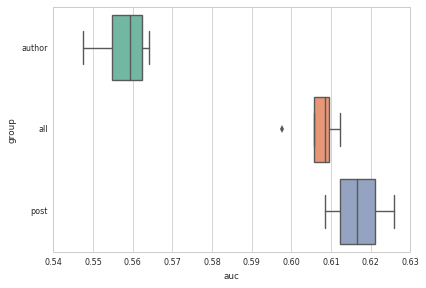

In [260]:
import seaborn as sns
sns.set(style="whitegrid", context="paper")
sns.set_color_codes("pastel")
g = sns.boxplot(x='roc_auc', y='group', data=results2_df, palette="Set2")
g.set(xlabel='auc')
# g.axvline(0.616460, 0, 1, color="red", ls='--')

In [72]:
tmp = []
for g in results:
    tmp += g

    results_df = pd.DataFrame(tmp, columns=['group', 'strata', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
results_df.head(25)

,group,strata,accuracy,f1,roc_auc,precision,recall
0,author,<20k,53.940067,58.291457,0.557075,0.536665,0.535763
1,author,20k-50k,55.131265,56.781609,0.564052,0.551727,0.551407
2,author,50k-130k,54.107981,55.819209,0.547181,0.540418,0.540484
3,author,130k+,54.724818,57.254902,0.561485,0.545898,0.545717
4,all,<20k,58.379578,61.851475,0.608577,0.582222,0.580857
5,all,20k-50k,58.233890,59.302326,0.611546,0.582653,0.582405
6,all,50k-130k,57.511737,58.769932,0.595415,0.574838,0.575010
7,all,130k+,58.566978,60.843965,0.608434,0.584560,0.584253
8,post,<20k,58.157603,63.574879,0.613475,0.580984,0.576001
9,post,20k-50k,56.801909,61.407249,0.619412,0.572521,0.568307


In [165]:
print(results_df.to_latex(index = False))

\begin{tabular}{llrrrrr}
\toprule
  group &    strata &   accuracy &         f1 &   roc\_auc &  precision &    recall \\
\midrule
 author &      <20k &  53.940067 &  58.291457 &  0.557075 &   0.536665 &  0.535763 \\
 author &   20k-50k &  55.131265 &  56.781609 &  0.564052 &   0.551727 &  0.551407 \\
 author &  50k-130k &  54.107981 &  55.819209 &  0.547181 &   0.540418 &  0.540484 \\
 author &     130k+ &  54.724818 &  57.254902 &  0.561485 &   0.545898 &  0.545717 \\
    all &      <20k &  58.379578 &  61.851475 &  0.608577 &   0.582222 &  0.580857 \\
    all &   20k-50k &  58.233890 &  59.302326 &  0.611546 &   0.582653 &  0.582405 \\
    all &  50k-130k &  57.511737 &  58.769932 &  0.595415 &   0.574838 &  0.575010 \\
    all &     130k+ &  58.566978 &  60.843965 &  0.608434 &   0.584560 &  0.584253 \\
   post &      <20k &  58.157603 &  63.574879 &  0.613475 &   0.580984 &  0.576001 \\
   post &   20k-50k &  56.801909 &  61.407249 &  0.619412 &   0.572521 &  0.568307 \\
   post & 

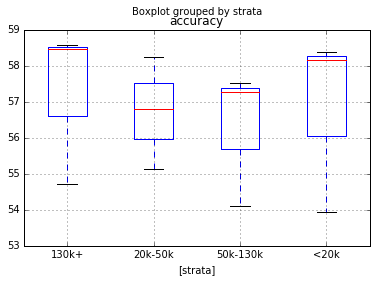

In [89]:
bp_labels = ['<20k', '20k-50k', '50k-130k', '130k+']
results_df.boxplot(column='accuracy', by=['strata'])

In [168]:
len(results)

0

In [175]:
all_features_results_df = pd.DataFrame(results, columns=['group', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
all_features_results_df.head(5)

,group,accuracy,f1,roc_auc,precision,recall
0,author,55.120990,59.854015,0.566442,0.549772,0.547808
1,post,56.246483,61.366460,0.586870,0.561794,0.558574
2,all,57.371975,61.243285,0.602434,0.572875,0.570964


In [172]:
all_features_results_df = pd.DataFrame(results, columns=['group', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
all_features_results_df.head(5)

,group,accuracy,f1,roc_auc,precision,recall
0,author,54.530107,57.762676,0.562472,0.543882,0.543314
1,post,55.936972,60.172940,0.573990,0.558159,0.556374
2,all,55.683737,58.672264,0.585306,0.555621,0.555009


In [66]:
results.keys()

dict_keys(['post + each group', 'all groups', 'supergroup_combinations'])

In [58]:
# results = {}

"""### process all flat features separately"""
# results['flat features'] = []
# for group in flat_features:
# #     print('Feature group: ' + group)
#     columns = get_labels(group)
#     for column in columns:
# #         print(column)
#         res = train_model(group, *get_subset(column), feature=column)
#         results['flat features'].append(res)
# print('flat feature groups done.')
        
"""### process all feature groups"""
results['all groups'] = []
for group in feature_groups:
#     print('Feature group: ' + group)
#     results[group] = []
#     res = train_model(group, *get_subset(get_labels(group)))
    res = train_model_test_stratified(group, *get_subset(get_labels(group)))
#     results['all groups'].append(res)
    results['all groups'] += res
print('all feature groups done.')

"""### process my feature group (without post feature groups)"""
# results['my groups'] = []
# columns = traits_beliefs_columns
# for group in my_groups:
# #     print('Feature group: ' + group)
#     results[group] = []
#     res = train_model(group, *get_subset(get_labels(group)))
#     results['my groups'].append(res)
# print('my feature groups done.')

"""### process each feature group + post features"""
results['post + each group'] = []
for group in feature_groups:
#     print('Feature group: ' + group)
    columns = post_columns + get_labels(group)
#     res = train_model(group, *get_subset(columns))
    res = train_model_test_stratified(group, *get_subset(columns))
#     results['post + each group'].append(res)
    results['post + each group'] += res
print('each feature group + post done.')

"""### ablation"""
results['ablation'] = []
for group in feature_groups:
#     print('Feature group: ' + group)
    columns = get_labels(group)
    res = train_model(group, *get_subset_drop(columns))
    results['ablation'].append(res)
print('ablation done.')


all feature groups done.
each feature group + post done.


In [272]:
results['all groups']

[{'accuracy': 52.231404958677686,
  'f1': 67.9245283018868,
  'group': 'belief_csim',
  'precision': 0.538425137232633,
  'recall': 0.5044432770810078,
  'roc_auc': 0.5230809639503579,
  'strata': '<170'},
 {'accuracy': 50.74626865671642,
  'f1': 66.4406779661017,
  'group': 'belief_csim',
  'precision': 0.4774305555555555,
  'recall': 0.496136318605112,
  'roc_auc': 0.487082535279484,
  'strata': '170-450'},
 {'accuracy': 50.90609555189456,
  'f1': 66.05922551252847,
  'group': 'belief_csim',
  'precision': 0.4988714337305886,
  'recall': 0.49972846747040295,
  'roc_auc': 0.4819485174323884,
  'strata': '450-990'},
 {'accuracy': 52.85234899328859,
  'f1': 67.95895096921322,
  'group': 'belief_csim',
  'precision': 0.5379103625463888,
  'recall': 0.5074936800288913,
  'roc_auc': 0.5323785662694114,
  'strata': '990-1820'},
 {'accuracy': 53.06479859894922,
  'f1': 68.01909307875896,
  'group': 'belief_csim',
  'precision': 0.5300690108445614,
  'recall': 0.5067552602436324,
  'roc_auc':

In [63]:
"""### process group_combinations"""

results['supergroup_combinations'] = []
for combination in supergroup_combinations:
    group_label = ' +'.join([g for g in combination])
    groups = []
    for sg in combination:
        groups += supergroups[sg]
#     print('groups',groups)
    print(group_label[:20]+' combination, supergroups:'+str(len(groups)))
    columns = []
    for g in groups:
        columns += get_labels(g)
#     print('columns',columns)
#     res = train_model(group_label, *get_subset(columns))
    res = train_model_test_stratified(group_label, *get_subset(columns))
#     results['supergroup_combinations'].append(res)
    results['supergroup_combinations'] += res
print('all feature groups done.')

belief_sim combination, supergroups:3
traits_flat combination, supergroups:1
traits_flat +belief_ combination, supergroups:4
traits_feat_b combination, supergroups:2
traits_feat_b +belie combination, supergroups:5
traits_feat_b +trait combination, supergroups:3
traits_feat_b +trait combination, supergroups:6
post combination, supergroups:3
post +belief_sim combination, supergroups:6
post +traits_flat combination, supergroups:4
post +traits_flat +b combination, supergroups:7
post +traits_feat_b combination, supergroups:5
post +traits_feat_b  combination, supergroups:8
post +traits_feat_b  combination, supergroups:6
post +traits_feat_b  combination, supergroups:9
traits_feat_r combination, supergroups:2
traits_feat_r +belie combination, supergroups:5
traits_feat_r +trait combination, supergroups:3
traits_feat_r +trait combination, supergroups:6
traits_feat_r +trait combination, supergroups:4
traits_feat_r +trait combination, supergroups:7
traits_feat_r +trait combination, supergroups:5
t

traits_feat_p +belie combination, supergroups:11
traits_feat_p +belie combination, supergroups:14
traits_feat_p +belie combination, supergroups:12
traits_feat_p +belie combination, supergroups:15
traits_feat_p +belie combination, supergroups:8
traits_feat_p +belie combination, supergroups:11
traits_feat_p +belie combination, supergroups:9
traits_feat_p +belie combination, supergroups:12
traits_feat_p +belie combination, supergroups:10
traits_feat_p +belie combination, supergroups:13
traits_feat_p +belie combination, supergroups:11
traits_feat_p +belie combination, supergroups:14
traits_feat_p +belie combination, supergroups:11
traits_feat_p +belie combination, supergroups:14
traits_feat_p +belie combination, supergroups:12
traits_feat_p +belie combination, supergroups:15
traits_feat_p +belie combination, supergroups:13
traits_feat_p +belie combination, supergroups:16
traits_feat_p +belie combination, supergroups:14
traits_feat_p +belie combination, supergroups:17
traits_feat_p +belie c

belief_sc +belief_ec combination, supergroups:16
belief_sc +belief_ec combination, supergroups:19
belief_sc +belief_ec combination, supergroups:17
belief_sc +belief_ec combination, supergroups:20
belief_sc +belief_ec combination, supergroups:17
belief_sc +belief_ec combination, supergroups:20
belief_sc +belief_ec combination, supergroups:18
belief_sc +belief_ec combination, supergroups:21
belief_sc +belief_ec combination, supergroups:19
belief_sc +belief_ec combination, supergroups:22
belief_sc +belief_ec combination, supergroups:20
belief_sc +belief_ec combination, supergroups:23
belief_sc +belief_ec combination, supergroups:16
belief_sc +belief_ec combination, supergroups:19
belief_sc +belief_ec combination, supergroups:17
belief_sc +belief_ec combination, supergroups:20
belief_sc +belief_ec combination, supergroups:18
belief_sc +belief_ec combination, supergroups:21
belief_sc +belief_ec combination, supergroups:19
belief_sc +belief_ec combination, supergroups:22
belief_sc +belief_ec

belief_sc +traits_fe combination, supergroups:25
belief_sc +traits_fe combination, supergroups:28
belief_sc +traits_fe combination, supergroups:26
belief_sc +traits_fe combination, supergroups:29
all feature groups done.


In [113]:
results2 = []
for k,v in results['supergroup_combinations'].items():
    results2.append(v)
print(len(results2))
results2[0]

511


{'accuracy': 59.060213843556554,
 'f1': 63.88682055100521,
 'group': 'traits_feat_p +post +belief_sec +belief_sim +traits_feat_r',
 'precision': 0.5915738465871019,
 'recall': 0.5867055505249195,
 'roc_auc': 0.6227753702590482}

In [148]:
from sklearn.feature_selection import RFE

clf = RandomForestClassifier(n_estimators=200)
rfe = RFE(clf, 100)
fit_rf200 = rfe.fit(X_train, y_train)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

KeyboardInterrupt: 

In [147]:
best_rf = list(X_train.columns[fit.support_])
len(best_rf)

100

In [146]:
res = train_model('best', *get_subset(best_rf))
res

{'accuracy': 59.96060776589758,
 'f1': 64.38047559449312,
 'group': 'best',
 'precision': 0.6005329985540908,
 'recall': 0.596048900319847,
 'roc_auc': 0.6349253077354273}

In [65]:
# combinations_results_df = pd.DataFrame(results['supergroup_combinations'], columns=['group', 'strata', 'feature', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
combinations_results_df.to_csv('/home/username/workspace/data/output/results/mypairs/strata_words_mypairs_combinations_lr.csv', encoding='utf-8', index=False)
# combinations_results_df.sort_values(by=['index'], inplace=True, ascending=False)
# combinations_results_df.head(50)
combinations_results_df.sort_values('accuracy').drop_duplicates(['group'],keep='last')

,group,strata,feature,accuracy,f1,roc_auc,precision,recall
1152,belief_sc +belief_sec +belief_sim,<20k,NaN,51.498335,60.380780,0.520054,0.506944,0.505829
1168,belief_sc +belief_sec +traits_feat_b +belief_sim,<20k,NaN,51.609323,59.328358,0.526907,0.509559,0.508510
383,belief_ec +belief_sec,130k+,NaN,51.609553,53.861386,0.516952,0.514969,0.514951
1419,belief_sc +belief_ec +belief_sec +traits_flat ...,130k+,NaN,51.817238,55.470250,0.521009,0.515820,0.515614
1161,belief_sc +belief_sec +traits_flat +belief_sim,20k-50k,NaN,51.909308,56.526429,0.511039,0.520285,0.519350
1176,belief_sc +belief_sec +traits_feat_b +traits_f...,<20k,NaN,51.942286,59.418932,0.528808,0.513481,0.512099
399,belief_ec +belief_sec +traits_feat_b,130k+,NaN,52.128764,55.024390,0.531782,0.519598,0.519488
1431,belief_sc +belief_ec +belief_sec +traits_feat_...,130k+,NaN,52.128764,56.385998,0.533363,0.518468,0.518071
1407,belief_sc +belief_ec +belief_sec,130k+,NaN,52.128764,56.053384,0.517133,0.518739,0.518425
1408,belief_sc +belief_ec +belief_sec +belief_sim,<20k,NaN,52.164262,55.794872,0.507819,0.519212,0.518980


In [96]:
filtered_df = combinations_results_df[combinations_results_df.group.map(lambda x: 'post' not in x)]

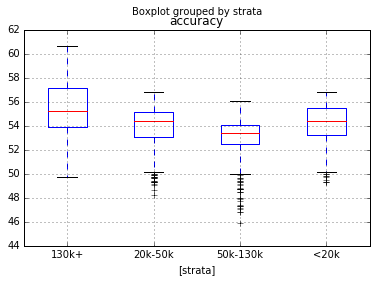

In [97]:
filtered_df.boxplot(column='accuracy', by=['strata'])

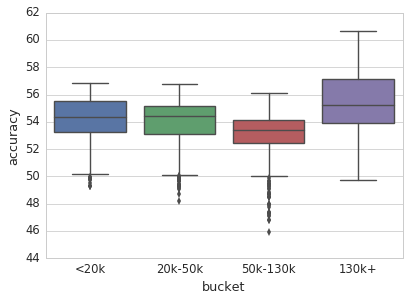

In [337]:
f, ax = plt.subplots()
sns.set(font_scale=1.45, style="whitegrid", context="paper")
sns.set_color_codes("pastel")

g = sns.boxplot(x='strata', y='accuracy', data=filtered_df)
g.set(xlabel='bucket', ylabel='accuracy')

f.savefig('/home/username/workspace/figures/boxplot_task1_acc.pdf', bbox_inches="tight")

In [271]:
# import matplotlib.pyplot as plt
# plt.savefig('/home/username/workspace/figures/boxplot_task1_acc.pdf')
# g.getfig().savefig('/home/username/workspace/figures/boxplot_task1_acc.png')

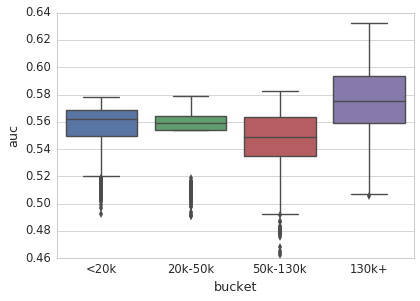

In [338]:
f, ax = plt.subplots()
sns.set(font_scale=1.45, style="whitegrid", context="paper")
sns.set_color_codes("pastel")

ax = sns.boxplot(x='strata', y='roc_auc', data=filtered_df).set(xlabel='bucket', ylabel='auc')

f.savefig('/home/username/workspace/figures/boxplot_task1_auc.pdf', bbox_inches="tight")

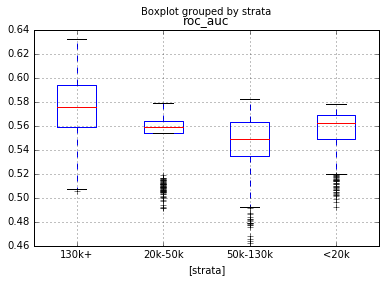

In [98]:
filtered_df.boxplot(column='roc_auc', by=['strata'])

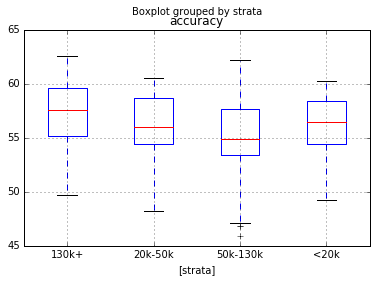

In [92]:
combinations_results_df.boxplot(column='accuracy', by=['strata'])

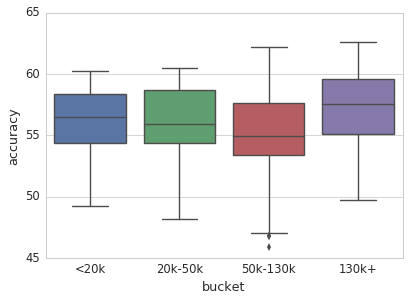

In [339]:
f, ax = plt.subplots()
sns.set(font_scale=1.45, style="whitegrid", context="paper")
sns.set_color_codes("pastel")

ax = sns.boxplot(x='strata', y='accuracy', data=combinations_results_df).set(xlabel='bucket', ylabel='accuracy')

f.savefig('/home/username/workspace/figures/boxplot_task1_full_acc.pdf', bbox_inches="tight")

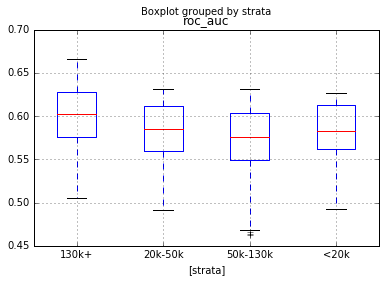

In [91]:
combinations_results_df.boxplot(column='roc_auc', by=['strata'])

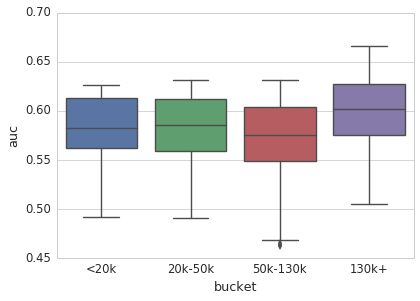

In [340]:
f, ax = plt.subplots()
sns.set(font_scale=1.45, style="whitegrid", context="paper")
sns.set_color_codes("pastel")

ax = sns.boxplot(x='strata', y='roc_auc', data=combinations_results_df).set(xlabel='bucket', ylabel='auc')

f.savefig('/home/username/workspace/figures/boxplot_task1_full_auc.pdf', bbox_inches="tight")

In [137]:
# lr_combinations_results_df = pd.DataFrame(results['supergroup_combinations'], columns=['group', 'feature', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
lr_combinations_results_df.to_csv('/home/username/workspace/data/output/results/mypairs/mypairs_combinations_lr.csv', encoding='utf-8', index=False)
# lr_combinations_results_df.sort_values(by=['index'], inplace=True, ascending=False)
# lr_combinations_results_df.head(5)

In [305]:
results.keys()

dict_keys(['all groups', 'post + each group', 'supergroup_combinations'])

In [61]:
supergroups = {}
supergroups['post'] = ['words', 'interplay_path', 'interplay_root']
supergroups['traits_flat'] = ['traits_sim']
supergroups['traits_feat_b'] = ['traits_feat_b', 'traits_feat_bdif']
supergroups['traits_feat_p'] = ['traits_feat_p', 'traits_feat_pdif']
supergroups['traits_feat_r'] = ['traits_feat_r', 'traits_feat_rdif']
supergroups['belief_sim'] = ['belief_ssim', 'belief_csim', 'belief_esim']
supergroups['belief_sc'] = ['belief_sim_scatr','belief_sim_scatt','belief_sim_scattp','belief_sim_spcatrp','belief_sim_stcatrp','belief_sim_stcattp']
# supergroups['belief_stc'] = ['belief_sim_stcatrp','belief_sim_stcattp']
supergroups['belief_ec'] = ['belief_sim_ecatp','belief_sim_ecatr','belief_sim_ecatt','belief_sim_etcatp','belief_sim_etcatr','belief_sim_etcatt']
# supergroups['belief_etc'] = ['belief_sim_etcatp','belief_sim_etcatr','belief_sim_etcatt']
supergroups['belief_sec'] = ['belief_sim_secat','belief_sim_secatp','belief_sim_setcat','belief_sim_setcatp']
# supergroups['belief_setc'] = ['belief_sim_setcat','belief_sim_setcatp']
len(supergroups)

9

In [166]:
supergroups.keys()

dict_keys(['belief_sim', 'traits_flat', 'traits_feat_b', 'post', 'traits_feat_r', 'belief_sec', 'belief_ec', 'traits_feat_p', 'belief_sc'])

In [175]:
supergroups_df = pd.DataFrame ([{'type': k, 'groups': v} for k,v in supergroups.items()], columns=['type','groups'])
pd.set_option('display.max_colwidth', -1)
print(supergroups_df.to_latex(multirow=True))

\begin{tabular}{lll}
\toprule
{} &           type &                                                                                                               groups \\
\midrule
0 &  belief\_sim &  [belief\_ssim, belief\_csim, belief\_esim] \\
1 &  traits\_flat &  [traits\_sim] \\
2 &  traits\_feat\_b &  [traits\_feat\_b, traits\_feat\_bdif] \\
3 &  post &  [words, interplay\_path, interplay\_root] \\
4 &  traits\_feat\_r &  [traits\_feat\_r, traits\_feat\_rdif] \\
5 &  belief\_sec &  [belief\_sim\_secat, belief\_sim\_secatp, belief\_sim\_setcat, belief\_sim\_setcatp] \\
6 &  belief\_ec &  [belief\_sim\_ecatp, belief\_sim\_ecatr, belief\_sim\_ecatt, belief\_sim\_etcatp, belief\_sim\_etcatr, belief\_sim\_etcatt] \\
7 &  traits\_feat\_p &  [traits\_feat\_p, traits\_feat\_pdif] \\
8 &  belief\_sc &  [belief\_sim\_scatr, belief\_sim\_scatt, belief\_sim\_scattp, belief\_sim\_spcatrp, belief\_sim\_stcatrp, belief\_sim\_stcattp] \\
\bottomrule
\end{tabular}



In [62]:
def combs(a):
    if len(a) == 0:
        return [[]]
    cs = []
    for c in combs(a[1:]):
        cs += [c, c+[a[0]]]
    return cs

supergroup_combinations = combs(list(supergroups.keys()))
supergroup_combinations.remove([])
len(supergroup_combinations)

511

In [293]:
supergroup_combinations

[['traits_flat'],
 ['traits_feat_b'],
 ['traits_feat_b', 'traits_flat'],
 ['belief_ec'],
 ['belief_ec', 'traits_flat'],
 ['belief_ec', 'traits_feat_b'],
 ['belief_ec', 'traits_feat_b', 'traits_flat'],
 ['traits_feat_r'],
 ['traits_feat_r', 'traits_flat'],
 ['traits_feat_r', 'traits_feat_b'],
 ['traits_feat_r', 'traits_feat_b', 'traits_flat'],
 ['traits_feat_r', 'belief_ec'],
 ['traits_feat_r', 'belief_ec', 'traits_flat'],
 ['traits_feat_r', 'belief_ec', 'traits_feat_b'],
 ['traits_feat_r', 'belief_ec', 'traits_feat_b', 'traits_flat'],
 ['belief_sc'],
 ['belief_sc', 'traits_flat'],
 ['belief_sc', 'traits_feat_b'],
 ['belief_sc', 'traits_feat_b', 'traits_flat'],
 ['belief_sc', 'belief_ec'],
 ['belief_sc', 'belief_ec', 'traits_flat'],
 ['belief_sc', 'belief_ec', 'traits_feat_b'],
 ['belief_sc', 'belief_ec', 'traits_feat_b', 'traits_flat'],
 ['belief_sc', 'traits_feat_r'],
 ['belief_sc', 'traits_feat_r', 'traits_flat'],
 ['belief_sc', 'traits_feat_r', 'traits_feat_b'],
 ['belief_sc', 'trai

In [125]:
results

{'ablation': [{'accuracy': 58.15981992121553,
   'f1': 60.35723806984803,
   'group': 'belief_csim',
   'precision': 0.5807576245535135,
   'recall': 0.5803793141932423,
   'roc_auc': 0.6061680883498076},
  {'accuracy': 58.244231851435,
   'f1': 60.552897395002645,
   'group': 'belief_esim',
   'precision': 0.5815807430838106,
   'recall': 0.5811180567709404,
   'roc_auc': 0.606702012169912},
  {'accuracy': 57.99099606077659,
   'f1': 60.67948380300238,
   'group': 'belief_sim_ecatp',
   'precision': 0.578980543140653,
   'recall': 0.5782442530266252,
   'roc_auc': 0.6155780200937981},
  {'accuracy': 58.525604952166574,
   'f1': 60.90185676392572,
   'group': 'belief_sim_ecatr',
   'precision': 0.5844010793616755,
   'recall': 0.5838577454464289,
   'roc_auc': 0.6097184915193621},
  {'accuracy': 58.55374226223973,
   'f1': 60.81404628890662,
   'group': 'belief_sim_ecatt',
   'precision': 0.5847027710932093,
   'recall': 0.5842458230923955,
   'roc_auc': 0.6057413297620043},
  {'accura

In [127]:
# flat_features_results_df = pd.DataFrame(results['flat features'], columns=['group', 'feature', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
flat_features_results_df.to_csv('/home/username/workspace/data/output/results/mypairs/flat_features.csv', encoding='utf-8', index=False)
flat_features_results_df.head(60)

,group,feature,accuracy,f1,roc_auc,precision,recall
0,belief_csim,belief_csim_category_raw,51.716376,68.175074,0.509602,0.258582,0.500000
1,belief_csim,belief_csim_category_tfidf,51.547552,66.922781,0.502567,0.500546,0.500108
2,belief_esim,belief_esim_entity_raw,51.857062,65.131445,0.512966,0.512923,0.506099
3,belief_esim,belief_esim_entity_tfidf,51.885200,67.453369,0.500701,0.520237,0.503025
4,belief_ssim,belief_ssim_subreddit_raw,50.731570,60.195499,0.501925,0.499681,0.499743
5,belief_ssim,belief_ssim_subreddit_tfidf,51.547552,67.484894,0.520607,0.492761,0.499238
6,interplay_path,interplay_path_words_common_all,53.123241,66.124441,0.505371,0.540332,0.518669
7,interplay_path,interplay_path_words_common_content,52.870006,64.078919,0.519115,0.528485,0.518600
8,interplay_path,interplay_path_words_common_stop,51.660101,66.744096,0.511254,0.506802,0.501622
9,interplay_path,interplay_path_words_jaccard_all,55.936972,64.066085,0.555573,0.563251,0.552255


In [177]:
flat_features_results_df2 = pd.DataFrame(results['flat features'], columns=['group', 'feature', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
# flat_features_results_df.to_csv('/home/username/workspace/data/output/results/mypairs/flat_features.csv', encoding='utf-8', index=False)
flat_features_results_df2.head(60)

,group,feature,accuracy,f1,roc_auc,precision,recall
0,belief_csim,belief_csim_category_raw,49.690490,52.522570,0.497345,0.495413,0.495441
1,belief_csim,belief_csim_category_tfidf,49.915588,52.609159,0.496441,0.497780,0.497791
2,belief_esim,belief_esim_entity_raw,49.690490,53.218210,0.501004,0.494835,0.494900
3,belief_esim,belief_esim_entity_tfidf,49.887451,52.595156,0.496492,0.497487,0.497500
4,belief_ssim,belief_ssim_subreddit_raw,49.887451,51.721334,0.486613,0.498157,0.498158
5,belief_ssim,belief_ssim_subreddit_tfidf,50.562746,52.474980,0.495758,0.504846,0.504841
6,interplay_path,interplay_path_words_common_all,51.350591,57.213561,0.505275,0.509964,0.509402
7,interplay_path,interplay_path_words_common_content,50.872257,58.349237,0.504400,0.503521,0.503153
8,interplay_path,interplay_path_words_common_stop,51.660101,58.321203,0.508542,0.512741,0.511718
9,interplay_path,interplay_path_words_jaccard_all,49.971863,53.552769,0.507862,0.497627,0.497659


In [301]:
results.keys()

dict_keys(['post + each group', 'supergroup_combinations'])

In [69]:
# all_groups_results_df = pd.DataFrame(results['all groups'], columns=['group', 'strata', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
all_groups_results_df.to_csv('/home/username/workspace/data/output/results/mypairs/strata_words_all_groups.csv', encoding='utf-8', index=False)
# all_groups_results_df.groupby('group').head(50)
all_groups_results_df.sort_values('accuracy').drop_duplicates(['group'],keep='last')

,group,strata,accuracy,f1,roc_auc,precision,recall
36,belief_sim_scatt,<20k,50.610433,65.098039,0.492105,0.469425,0.488226
32,belief_sim_scatr,<20k,51.276360,65.186360,0.501244,0.489856,0.495608
47,belief_sim_secat,130k+,52.128764,58.431019,0.525624,0.516886,0.515768
56,belief_sim_setcatp,<20k,52.164262,64.053378,0.507354,0.512291,0.507643
8,belief_sim_ecatp,<20k,52.275250,63.804714,0.502239,0.514296,0.509312
2,belief_csim,50k-130k,52.816901,68.044515,0.528522,0.532164,0.505908
111,traits_sim,130k+,52.855659,68.818681,0.533463,0.707023,0.507681
15,belief_sim_ecatr,130k+,52.855659,58.576642,0.527482,0.524945,0.523626
72,belief_ssim,<20k,52.941176,64.006791,0.533583,0.524351,0.516491
24,belief_sim_etcatr,<20k,53.052164,68.027211,0.509981,0.549799,0.510265


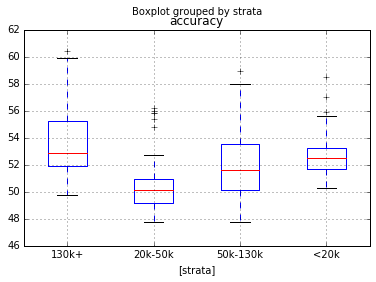

In [93]:
all_groups_results_df.boxplot(column='accuracy', by=['strata'])

In [149]:
# all_groups_results_df2 = pd.DataFrame(results['all groups'], columns=['group', 'feature', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
# all_groups_results_df2.to_csv('/home/username/workspace/data/output/results/mypairs/all_groups.csv', encoding='utf-8', index=False)
all_groups_results_df2.head(60)

NameError: name 'all_groups_results_df2' is not defined

In [71]:
# post_plus_groups_results_df = pd.DataFrame(results['post + each group'], columns=['group', 'strata', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
post_plus_groups_results_df.to_csv('/home/username/workspace/data/output/results/mypairs/strata_words_post_feature_groups.csv', encoding='utf-8', index=False)
# post_plus_groups_results_df.head(25)
post_plus_groups_results_df.sort_values('accuracy').drop_duplicates(['group'],keep='last')

,group,strata,accuracy,f1,roc_auc,precision,recall
8,belief_sim_ecatp,<20k,57.602664,63.962264,0.595364,0.576237,0.569175
35,belief_sim_scatr,130k+,58.047767,61.302682,0.614622,0.579051,0.577944
109,traits_sim,20k-50k,58.233890,62.526767,0.619053,0.587294,0.582616
115,words,130k+,58.463136,64.157706,0.625939,0.585227,0.578916
83,interplay_root,130k+,58.463136,64.157706,0.625969,0.585227,0.578916
79,interplay_path,130k+,58.463136,64.157706,0.625986,0.585227,0.578916
55,belief_sim_setcat,130k+,58.463136,62.192817,0.624474,0.583333,0.581485
12,belief_sim_ecatr,<20k,58.490566,64.981273,0.613637,0.586672,0.577668
48,belief_sim_secatp,<20k,58.601554,64.237776,0.610635,0.586145,0.580045
3,belief_csim,130k+,58.670820,64.079422,0.627983,0.587022,0.581351


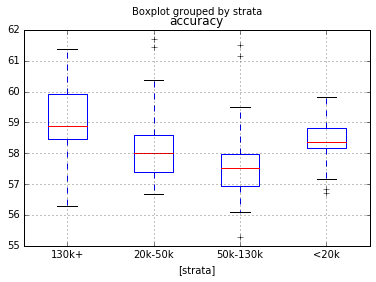

In [94]:
post_plus_groups_results_df.boxplot(column='accuracy', by=['strata'])

In [180]:
post_plus_groups_results_df2 = pd.DataFrame(results['post + each group'], columns=['group', 'feature', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
# post_plus_groups_results_df.to_csv('/home/username/workspace/data/output/results/mypairs/post_feature_groups.csv', encoding='utf-8', index=False)
post_plus_groups_results_df2.head(60)

,group,feature,accuracy,f1,roc_auc,precision,recall
0,belief_csim,NaN,56.781092,61.904762,0.593803,0.567500,0.563858
1,belief_esim,NaN,56.640405,61.638038,0.594796,0.565893,0.562595
2,belief_sim_ecatp,NaN,55.965110,58.869908,0.591279,0.558485,0.557884
3,belief_sim_ecatr,NaN,57.794035,62.140333,0.601009,0.577546,0.574677
4,belief_sim_ecatt,NaN,57.568936,60.810811,0.601897,0.574724,0.573525
5,belief_sim_etcatp,NaN,55.824423,58.222459,0.586054,0.557234,0.556930
6,belief_sim_etcatr,NaN,57.597074,62.503110,0.596512,0.575997,0.572154
7,belief_sim_etcatt,NaN,57.062465,61.869065,0.589495,0.570217,0.566966
8,belief_sim_scatr,NaN,57.568936,61.313494,0.587616,0.574854,0.573042
9,belief_sim_scatt,NaN,57.203151,58.133774,0.598117,0.571865,0.571942


In [132]:
# ablation_results_df = pd.DataFrame(results['ablation'], columns=['group', 'feature', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
ablation_results_df.to_csv('/home/username/workspace/data/output/results/mypairs/ablation.csv', encoding='utf-8', index=False)
ablation_results_df.head(60)

,group,feature,accuracy,f1,roc_auc,precision,recall
0,belief_csim,NaN,58.159820,60.357238,0.606168,0.580758,0.580379
1,belief_esim,NaN,58.244232,60.552897,0.606702,0.581581,0.581118
2,belief_sim_ecatp,NaN,57.990996,60.679484,0.615578,0.578981,0.578244
3,belief_sim_ecatr,NaN,58.525605,60.901857,0.609718,0.584401,0.583858
4,belief_sim_ecatt,NaN,58.553742,60.814046,0.605741,0.584703,0.584246
5,belief_sim_etcatp,NaN,58.216095,60.599629,0.607192,0.581284,0.580769
6,belief_sim_etcatr,NaN,58.187957,60.499734,0.605271,0.581014,0.580555
7,belief_sim_etcatt,NaN,58.103545,60.472525,0.606581,0.580154,0.579661
8,belief_sim_scatr,NaN,58.103545,60.639704,0.607320,0.580129,0.579506
9,belief_sim_scatt,NaN,58.328644,60.496132,0.606795,0.582461,0.582089


In [181]:
ablation_results_df2 = pd.DataFrame(results['ablation'], columns=['group', 'feature', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
# ablation_results_df.to_csv('/home/username/workspace/data/output/results/mypairs/ablation.csv', encoding='utf-8', index=False)
ablation_results_df2.head(60)

,group,feature,accuracy,f1,roc_auc,precision,recall
0,belief_csim,NaN,58.806978,63.011622,0.613730,0.588037,0.584857
1,belief_esim,NaN,57.203151,60.565206,0.591769,0.571011,0.569776
2,belief_sim_ecatp,NaN,58.019133,62.304194,0.606125,0.579853,0.576969
3,belief_sim_ecatr,NaN,58.272369,62.312579,0.599963,0.582302,0.579727
4,belief_sim_ecatt,NaN,57.765898,62.484379,0.608954,0.577592,0.574018
5,belief_sim_etcatp,NaN,57.822172,61.944656,0.604688,0.577674,0.575181
6,belief_sim_etcatr,NaN,59.088351,62.737058,0.615306,0.590471,0.588215
7,belief_sim_etcatt,NaN,57.175014,60.136197,0.603775,0.570712,0.569872
8,belief_sim_scatr,NaN,57.484524,61.620523,0.611618,0.574170,0.571820
9,belief_sim_scatt,NaN,58.159820,62.515755,0.611684,0.581392,0.578291
